In [45]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [46]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_sx1.fits'],
      dtype='<U67')

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24010_x1d.fits
G140L
[513.2145]


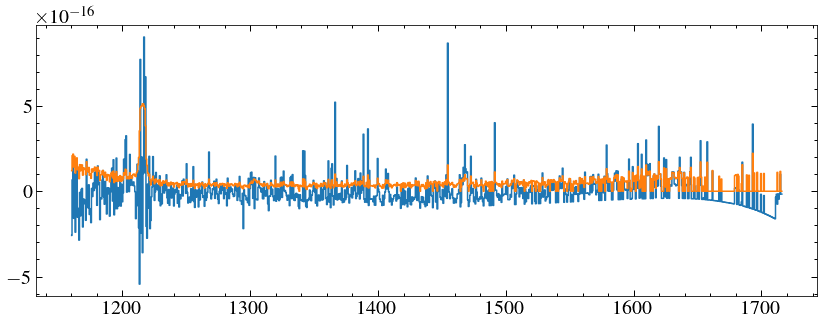

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24020_x1d.fits
G140L
[512.62335]


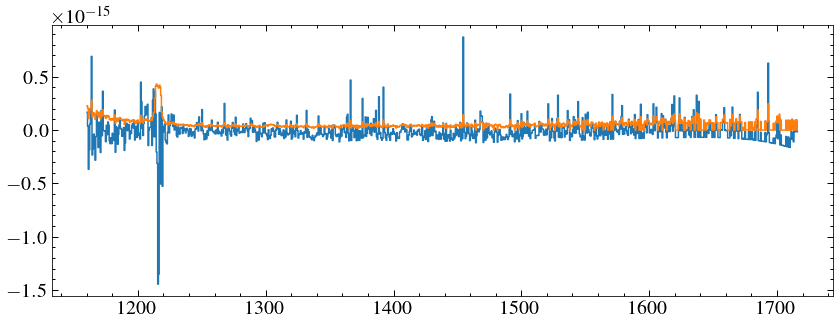

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24030_x1d.fits
G140L
[512.64307]


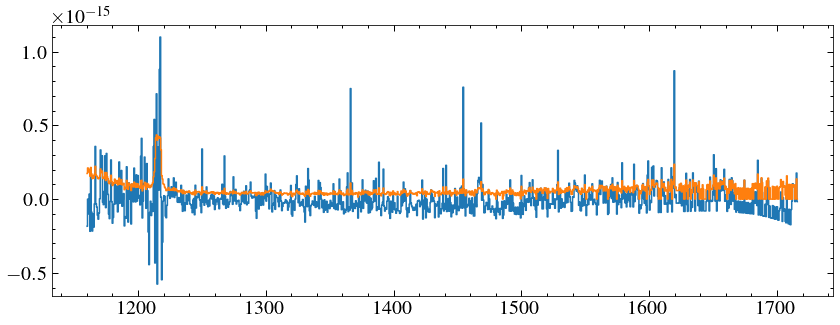

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_x1d.fits
G230L
[492.99686]


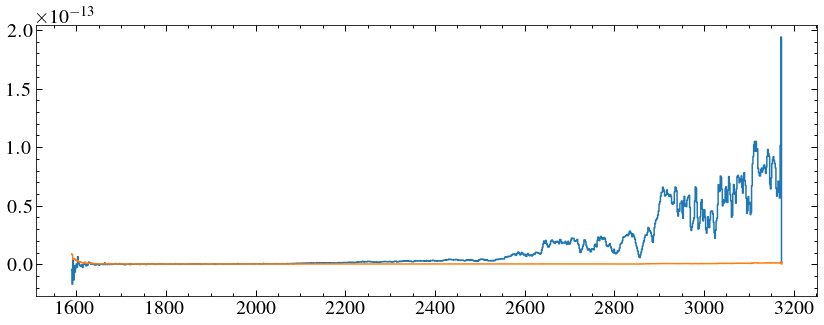

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_x1d.fits
G140M
[872.3185]


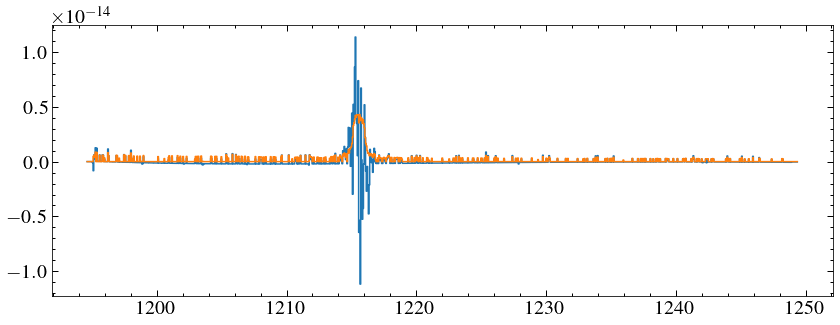

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_sx1.fits
G430L
[894.11395]


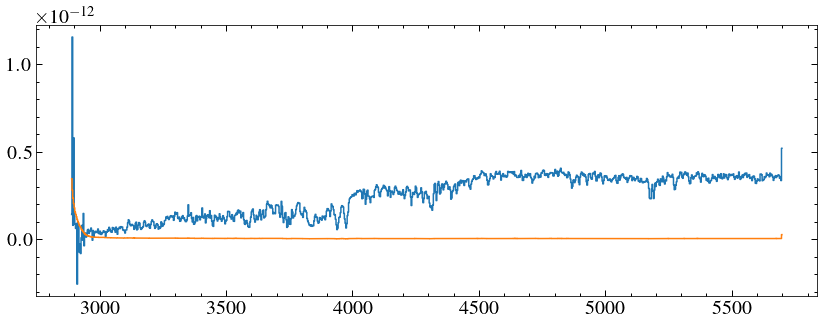

In [47]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()

    

/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_x1d.fits
G230L
[492.99686]
/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_x1d.fits
G140M
[872.3185]
/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_sx1.fits
G430L
[894.11395]


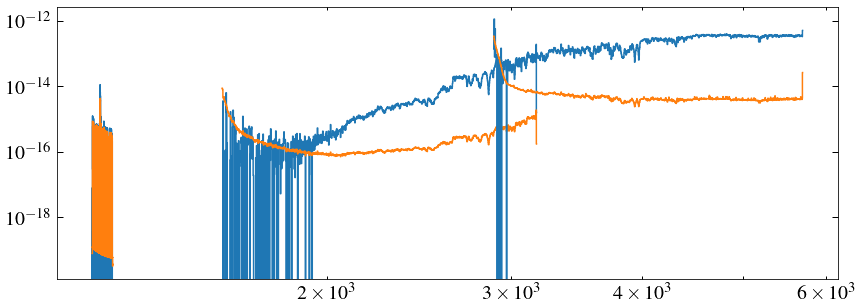

In [4]:
for x in x1ds[3:]:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')


plt.yscale('log')
plt.xscale('log')

plt.show()





In [5]:
flts = glob.glob('{}*flt.fits'.format(path))
flts

['/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24020_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24030_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24040_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24050_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oen301010_flt.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/toi-421/oeoo24010_flt.fits']

oeoo24020


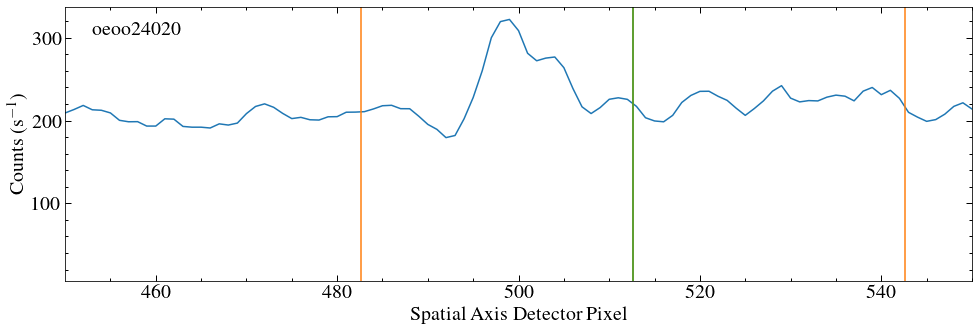

oeoo24030


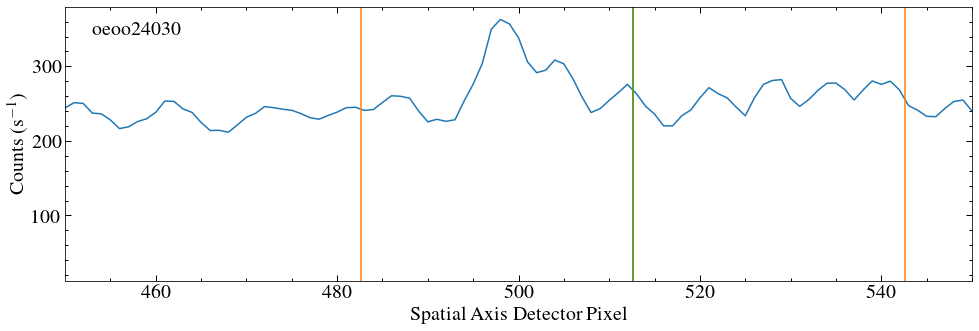

oeoo24010


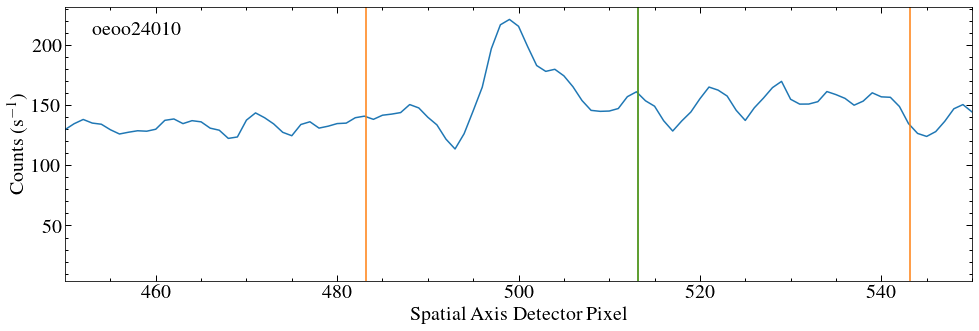

In [6]:
checkrow = 200
for flt in flts:
    hdr = fits.getheader(flt, 0)
    grating, root = hdr['OPT_ELEM'], hdr['ROOTNAME']
    if grating == 'G140L':       
        print(root)
        data = fits.getdata(flt, 1)
        data = np.transpose(data) #flip the image to make the next row more simple
        data = data[350:800]
        data = np.sum(data, axis=0)
        data = convolve(data,  Box1DKernel(4))
        plt.plot(np.arange(len(data)), data)
        
        spec = fits.getdata('{}{}_x1d.fits'.format(path, root))[0]
        [plt.axvline(line, c='C1') for line in (spec['A2CENTER'], spec['A2CENTER']+spec['BK1OFFST'], spec['A2CENTER']+spec['BK2OFFST'])]
        plt.axvline(spec['A2CENTER'], c='C2')      
        plt.ylabel('Counts (s$^{-1}$)')
        plt.xlabel('Spatial Axis Detector Pixel')
        plt.annotate('{}'.format(root), (0.03, 0.95), xycoords='axes fraction', ha='left', va='top')
        plt.xlim(450, 550)
        plt.tight_layout()
        plt.show()

Need to re-extract the G140L (+ maybe G140M) spectra. S/N is really low, might need to coadd flats before extracting.

In [7]:
import stistools
os.environ['oref'] = path

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [8]:
# for root in  ['oeoo24010', 'oeoo24020', 'oeoo24030']:

#     raw = '{}/{}_flt.fits'.format(path, root)
#     rootname = fits.getheader(raw)['ROOTNAME'] 
#     outname = 'reextractions/{}_new_x1d.fits'.format(rootname)
#     stistools.x1d.x1d(raw, output = outname, trailer='reextractions/{}_new.trl'.format(rootname), a2center=495, maxsrch=10)

499.70148


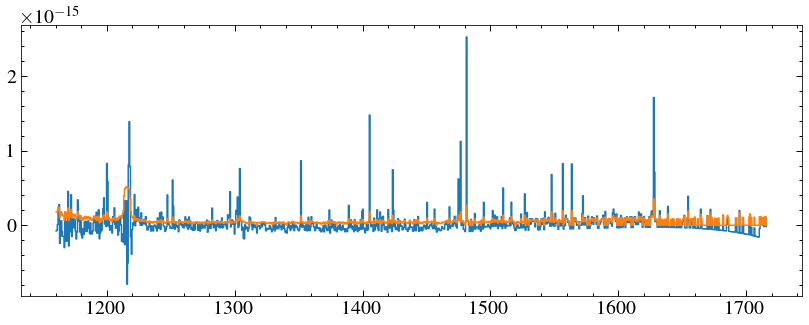

499.15488


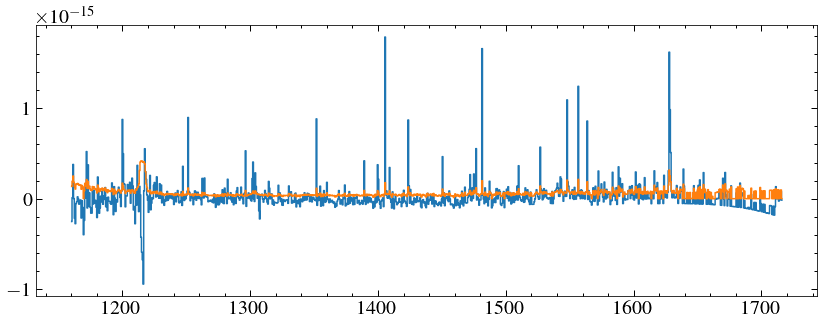

499.12582


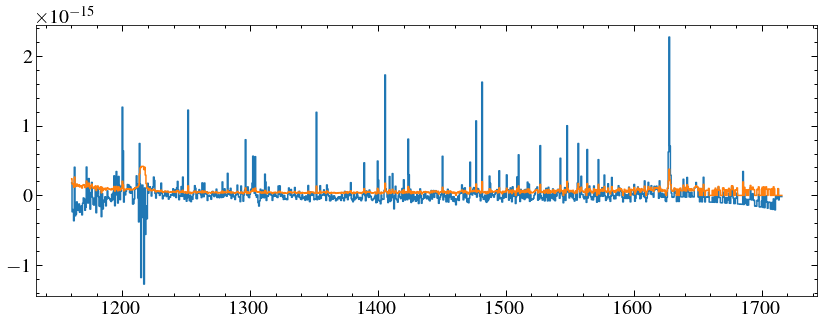

In [9]:
for root in  ['oeoo24010', 'oeoo24020', 'oeoo24030']:
        data = fits.getdata('reextractions/{}_new_x1d.fits'.format(root), 1)[0]
        print(data['A2Center'])
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        mask = w > 1160
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid')
        plt.step(w, e, where='mid')
        plt.show()

Tried with a2center = 495, 500, looks like that's as good as it's going to get

In [10]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

In [11]:
new_x1ds = glob.glob('reextractions/*240*x1d*')
new_x1ds

['reextractions/oeoo24030_new_x1d.fits',
 'reextractions/oeoo24020_new_x1d.fits',
 'reextractions/oeoo24010_new_x1d.fits']

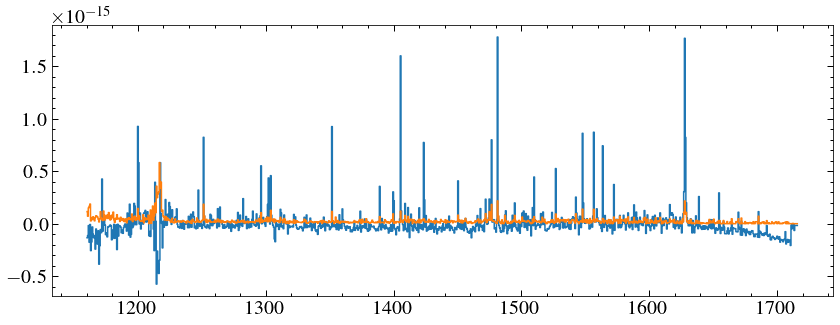

In [12]:
w_fuv = []
f_fuv = []
e_fuv = []

n=0
for x in new_x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G140L':
        mask = (w > 1160)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        n +=1

f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)

plt.step(w_fuv, f_fuv, where='mid')
plt.step(w_fuv, e_fuv, where='mid')

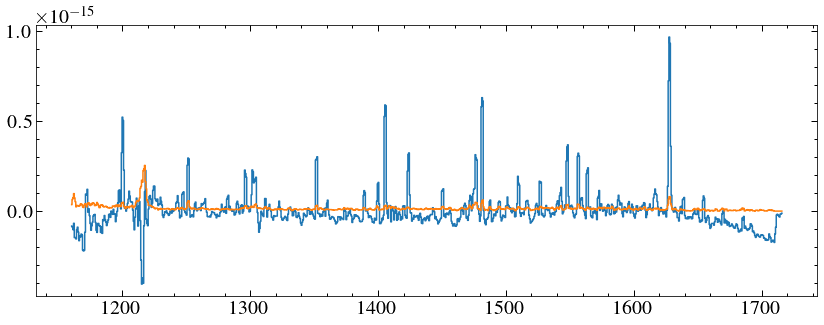

In [13]:
fi = convolve(f_fuv,  Box1DKernel(3))
ei = convolve(e_fuv,  Box1DKernel(3))/3**0.5
plt.step(w_fuv, fi, where='mid')
plt.step(w_fuv, ei, where='mid')


In [14]:
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1700) & (w <3130)
        w_nuv, f_nuv, e_nuv = w[mask], f[mask], e[mask]
    if grating == 'G430L':
        mask = (w > 3000) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]

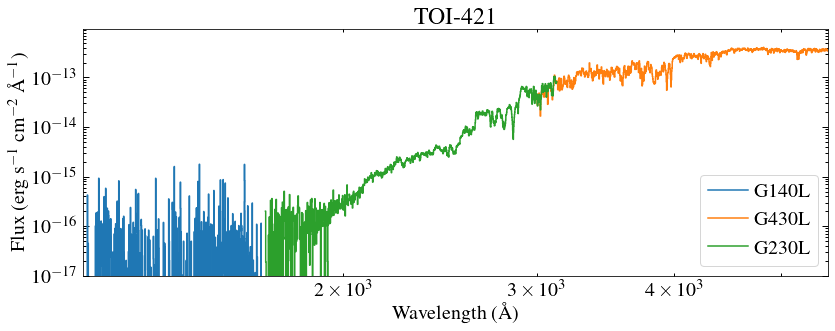

In [72]:
plt.figure(figsize=(12, 5))

plt.step(w_fuv, f_fuv, where='mid', label ='G140L')
plt.step(w_opt, f_opt, where='mid', label='G430L')
plt.step(w_nuv, f_nuv, where='mid', label='G230L')


plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-17)
plt.xlim(1160, 5520)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
plt.title('TOI-421')
plt.tight_layout()
plt.savefig('plots/toi-421_ql.pdf')
plt.savefig('plots/toi-421_ql.png', facecolor='w')

In [87]:
import importlib
import prepare_stis
importlib.reload(prepare_stis)

<module 'prepare_stis' from '/home/david/work/meats/SEDs/prepare_stis.py'>

/home/david/work/meats/SEDs/prepare_stis.py:33: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


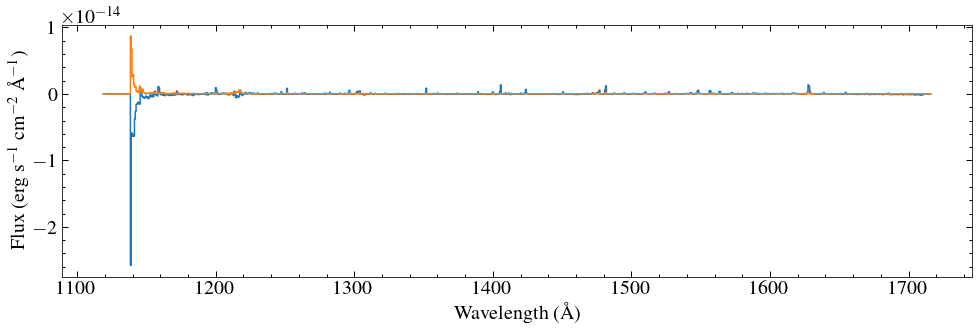

Spectrum saved as hlsp_muscles_hst_stis_bd-14-1137_g140l_v1_component-spec.fits


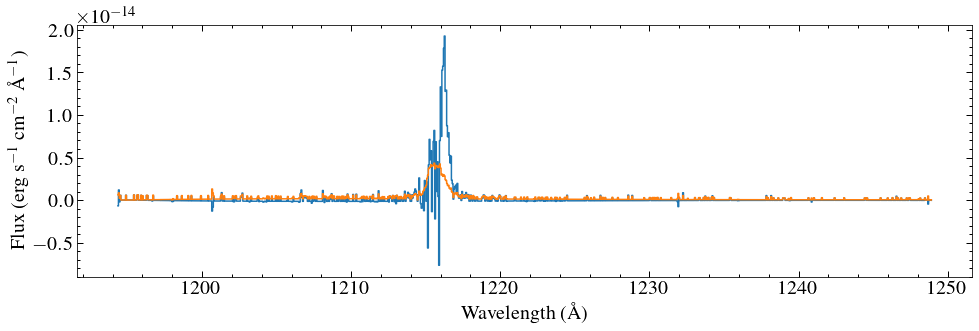

Spectrum saved as hlsp_muscles_hst_stis_bd-14-1137_g140m_v1_component-spec.fits


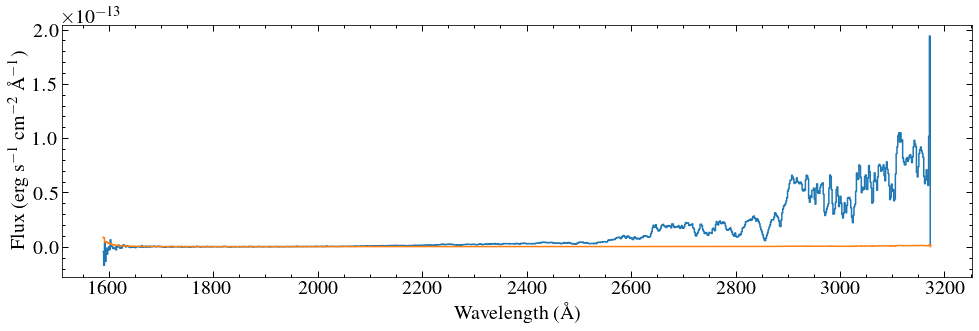

Spectrum saved as hlsp_muscles_hst_stis_bd-14-1137_g230l_v1_component-spec.fits


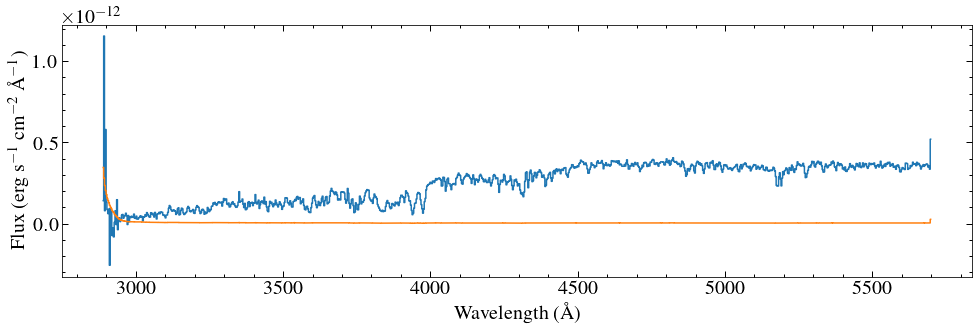

Spectrum saved as hlsp_muscles_hst_stis_bd-14-1137_g430l_v1_component-spec.fits


In [90]:
# make_stis_spectum(x1dpath, version,savepath = '', plot=False, save_ecsv=False, save_fits=False, return_data=False, return_gratings = False, normfac=1.0, sx1 = True)
goodpath = '{}/spectra_for_hlsp/'.format(path) #path where the final spectra are.
savepath = 'draft_hlsp/toi-421/'
version = 1
prepare_stis.make_stis_spectrum(goodpath, version, savepath=savepath, plot=True, save_fits=True, star='TOI-421')

In [89]:
fits.getheader('draft_hlsp/toi-421/hlsp_muscles_hst_stis_toi-421_g140l_v1_component-spec.fits', 0)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'HST     '                                                            
INSTRUME= 'STIS    '                                                            
GRATING = 'G140L   '                                                            
APERTURE= '52X0.2  '                                                            
TARGNAME= 'TOI-421 '                                                            
RA_TARG =    81.85321251806999                                                  
DEC_TARG=      -14.27663930912                                                  
PROPOSID=                16701                                                  
HLSPNAME= 'MUSCLES Extension

draft_hlsp/toi-421/hlsp_muscles_hst_stis_bd-14-1137_g430l_v1_component-spec.fits
G430L
[3160, 5690]
draft_hlsp/toi-421/hlsp_muscles_hst_stis_bd-14-1137_g140l_v1_component-spec.fits
G140L
[1160, 1650]
draft_hlsp/toi-421/hlsp_muscles_hst_stis_bd-14-1137_g230l_v1_component-spec.fits
G230L
[1700, 3160]


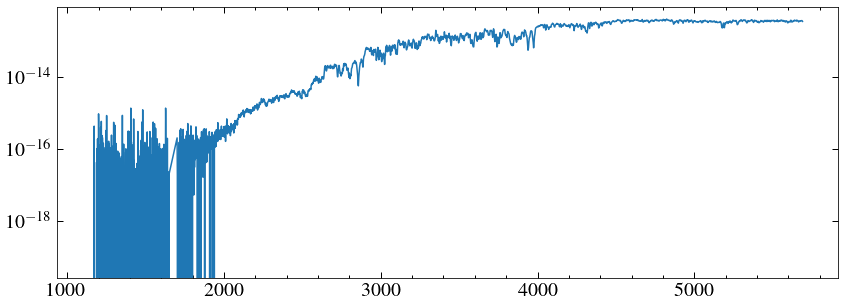

In [84]:
#good spectral ranges, incorporate into SED builder later
goodbands = dict(G140L=[1160,1650], G230L=[1700, 3160], G430L=[3160, 5690])
specs = glob.glob('draft_hlsp/toi-421/*stis*')
# specs
w_stis = np.array([], dtype=float)
f_stis = np.array([], dtype=float)
e_stis = np.array([], dtype=float)

gratings = []
for spec in specs:
    print (spec)
    grating = fits.getheader(spec, 0)['GRATING']
    if grating != 'G140M': #only used for Lya fitting
        print (grating)
        data = fits.getdata(spec, 1)
        band = goodbands[grating]
        print(band)
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        mask = (w > band[0]) & (w < band[1])
        w, f, e = w[mask], f[mask], e[mask]
        w_stis = np.hstack((w_stis, w))
        f_stis = np.hstack((f_stis, f))   
        e_stis = np.hstack((e_stis, e))  
args = np.argsort(w_stis)
w_stis, f_stis, e_stis = w_stis[args], f_stis[args], e_stis[args]
plt.plot(w_stis, f_stis)
plt.yscale('log')

Testing the Sun as a proxy, seeing how scaling by distance works out

In [80]:
data = Table.read('Solar_1au_sed.ecsv')
w_sol, f_sol = data['WAVELENGTH'], data['FLUX']
# plt.plot(w_sol, f_sol)

4.201288800154684e-15


(1e-19, 9.475542432898187e-12)

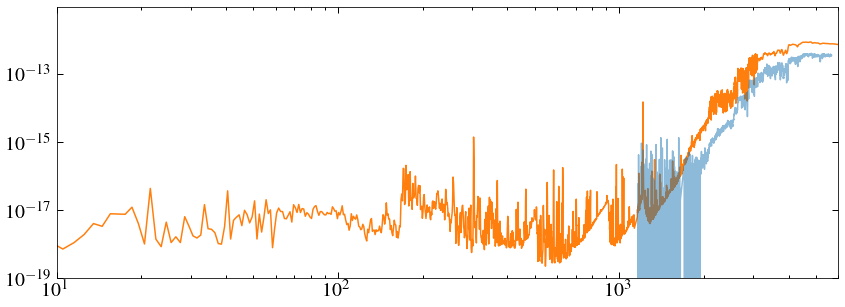

In [81]:
d_421 = 74.7969*u.pc
proxyscale = (((1*u.au).to(u.pc)) / d_421)**2
print(proxyscale)
plt.plot(w_stis, f_stis, alpha=0.5)
plt.plot(w_sol, f_sol*proxyscale, zorder=-1)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10, 6000)
plt.ylim(1e-19)


What about setting the intergrated FUV flux to be the same?

9.337436584600964e-15 6.3598337
1.468188792284534e-15


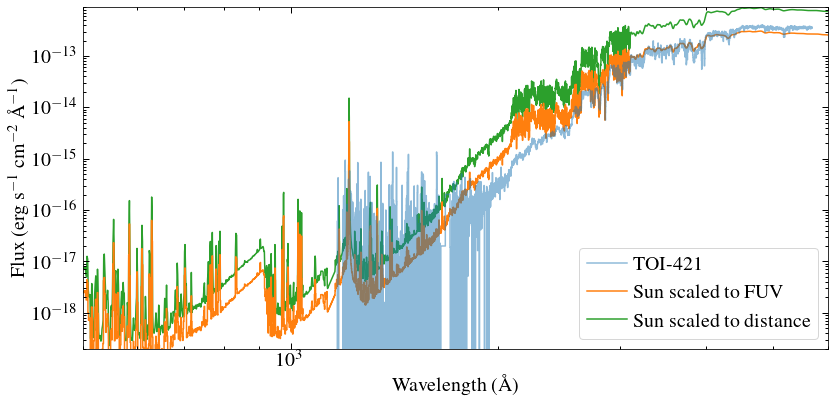

In [82]:
starmask = (w_stis > 1160) & (w_stis < 1210) | (w_stis > 1220) & (w_stis < 1700)#cut out lya 
sunmask = (w_sol > 1160) & (w_sol < 1210) | (w_sol > 1220) & (w_sol < 1700)#cut out lya
fuvstar = np.trapz(f_stis[starmask], w_stis[starmask])
fuvsol = np.trapz(f_sol[sunmask], w_sol[sunmask])
print(fuvstar, fuvsol)
fuv_ratio = fuvstar/fuvsol
print(fuv_ratio)

fig, ax= plt.subplots(figsize =(12, 6))

plt.step(w_stis, f_stis, alpha=0.5, where='mid', label = 'TOI-421')
plt.step(w_sol, f_sol*fuv_ratio, zorder=-1, where='mid', label='Sun scaled to FUV')
plt.plot(w_sol, f_sol*proxyscale, zorder=-2, label='Sun scaled to distance')

plt.yscale('log')
plt.xscale('log')
plt.xlim(500, 6000)
plt.ylim(2e-19, 9e-13)

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend(frameon=True, loc=4)
# plt.title('TOI-421')



plt.tight_layout()
plt.savefig('plots/toi-421_fuvsun.pdf')
plt.savefig('plots/toi-421_fuvsun.png', facecolor='w')


or NUV

1.2023457379848937e-11 14148.625
8.497968798981482e-16


(1e-19, 4.579736815924817e-12)

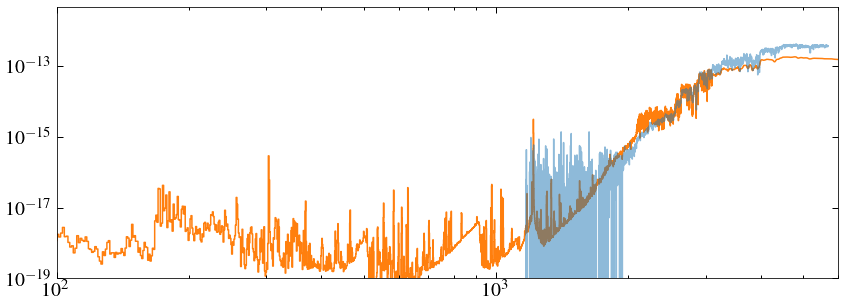

In [63]:
starmask = (w_stis > 1700) & (w_stis < 3000) 
sunmask = (w_sol > 1700) & (w_sol < 3000) 
nuvstar = np.trapz(f_stis[starmask], w_stis[starmask])
nuvsol = np.trapz(f_sol[sunmask], w_sol[sunmask])
print(nuvstar, nuvsol)
nuv_ratio = nuvstar/nuvsol
print(nuv_ratio)

plt.step(w_stis, f_stis, alpha=0.5, where='mid')
plt.step(w_sol, f_sol*nuv_ratio, zorder=-1,where='mid')
plt.yscale('log')
plt.xscale('log')
plt.xlim(100, 6000)
plt.ylim(1e-19)

In [25]:
print(fuv_ratio/nuv_ratio)
print(fuv_ratio/proxyscale)

1.3337771677544383
0.26978380434008237


Similar ish. Maybe FUV, as NUV still has photosphere contribution.  

Might need to cut down the FUV and NUV join a bit more and fill with a ploynomial

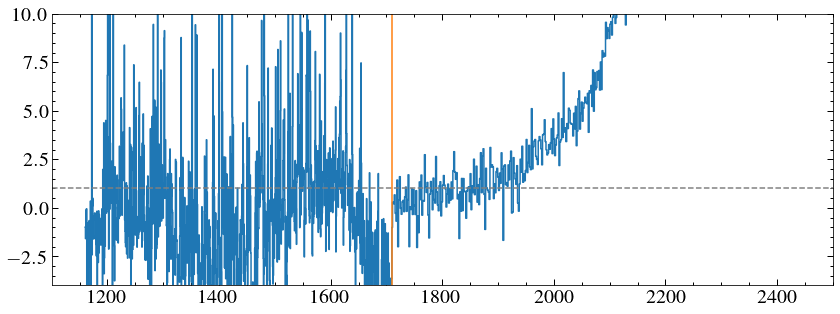

In [26]:
plt.step(w_stis, f_stis/e_stis, where='mid')
plt.axhline(1, ls='--', c='0.5')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(1100, 2500)
plt.ylim(-4, 10)
plt.axvline(goodbands['G140L'][1], c='C1')

In [44]:
# #open fancy solar spectrum
# import netCDF4 as nc
# tsis = nc.Dataset('../hybrid_reference_spectrum_c2021-03-04_with_unc.nc')
# wssi, fssi = np.array(tsis.variables['Vacuum Wavelength']), np.array(tsis.variables['SSI'])

# # plt.plot(tsis.variables['Vacuum Wavelength'], tsis.variables['SSI'])
# plt.plot(wssi*10, fssi)
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(w_sol, f_sol)

<class 'netCDF4._netCDF4.Variable'>
float64 Vacuum Wavelength(wavelength)
    long_name: Wavelength grid center
    units: nm
    standard_name: radiation_wavelength
unlimited dimensions: 
current shape = (2528000,)
filling on, default _FillValue of 9.969209968386869e+36 used

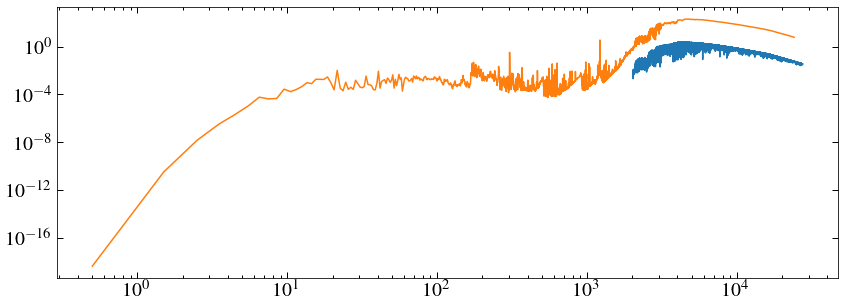

In [52]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

def remove_negatives(w, f, e):
    """
    Iteratvly removes negative values by combining them with adjecent bins
    """
    wn, fn, en = w, f, e  
    nz = len(fn[fn <0.0]) 
#     print(nz)
    minfi = np.argmin(fn) # most negative point
    fi = fn[minfi]
    while fi < 0:
        if len(fn) > 2: #can't handle an array less than 2 long
            w0, w1 = wavelength_edges(wn)
            delinds = [] #indices to delete when we're done
            start, end = minfi-1, minfi+2
            if minfi == 0: 
                start = minfi
            elif minfi == len(fn)-1:
                end = minfi +1
            delinds.append(start)
            delinds.append(end-1)
            fi = np.sum(fn[start:end]*(w1[start:end]-w0[start:end])) / (w1[end-1] - w0[start])
            ei = (np.sum(en[start:end]**2 * (w1[start:end]-w0[start:end])**2))**0.5                
            wi = (w0[start]+w1[end-1])/2
            wn[minfi], fn[minfi], en[minfi] = wi, fi, ei
            delinds = np.array(delinds)
            delinds = np.unique(delinds[(delinds != minfi) & (delinds >= 0) & (delinds < len(fn)-1)])
            wn, fn, en  = np.delete(wn, delinds), np.delete(fn, delinds), np.delete(en, delinds)
            minfi = np.argmin(fn) # most negative point
            fi = fn[minfi]
            nz = len(fn[fn <0.0])
#             print('len', len(fn))
#             print(nz)
        else:
            fi = 1e9
    return(wn[fn >0], fn[fn >0], en[fn >0])

In [53]:
print(np.trapz(f_stis, w_stis))
wneg, fneg, eneg = remove_negatives(w_stis, f_stis, e_stis)
print(np.trapz(fneg, wneg))


6.910881771640128e-10
6.911286522949278e-10


(1e-19, 4.579736815924817e-12)

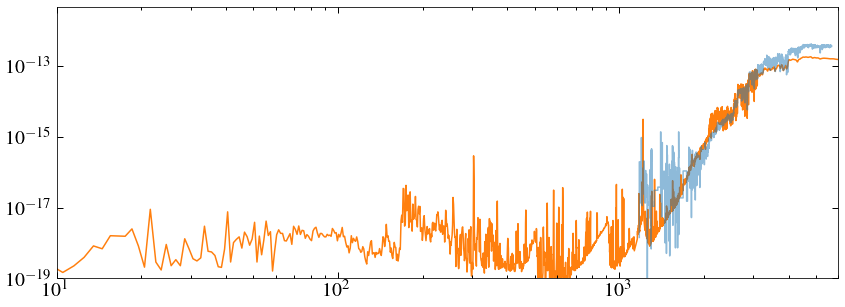

In [59]:
plt.step(wneg, fneg, alpha =0.5)

plt.plot(w_sol, f_sol*nuv_ratio, zorder=-1)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10, 6000)
plt.ylim(1e-19)